In [10]:
import os, sys, time, pickle, datetime, re, io, pytz

import numpy  as np
#import math, datetime, re, json

import matplotlib.pyplot as plt
from   matplotlib.dates import DateFormatter, MinuteLocator
#from   matplotlib import ticker

import pandas as pd
from   pandas.core.tools.datetimes import _guess_datetime_format_for_array
#import fastparquet
import plotly.express as px
#import seaborn as sns
#import plotly.graph_objs as go
#from   tqdm import tqdm

#from dto_classes import dto_chargeup
#from qmax_features import data_loss
from os.path import isfile, join

# import openpyxl
# import xlwings
# import bz2
import _pickle as cPickle

#import scipy.interpolate         as sp_interpolate
#import scipy.cluster.hierarchy   as sp_clust_hierarchy
#import scipy.ndimage             as sp_ndimage
#import scipy.stats               as sp_stats
#from   scipy.signal            import find_peaks       as scipy_find_peaks
#from   scipy.ndimage           import uniform_filter1d as scipy_uniform_filter1d
#from   scipy.spatial           import distance         as scipy_distance

from scipy.stats.mstats import winsorize

#from   scipy.cluster.hierarchy import dendrogram, linkage, fcluster, ward
#from   scipy.interpolate       import splev, splrep

#from   itertools import combinations
#from   tsmoothie import LowessSmoother

from   functools import reduce
from IPython.display import display, HTML

#import base64
#from io import BytesIO

# import tabulate

# import warnings
#warnings.filterwarnings("ignore")

from importlib import reload
import eChargeUp_utils
#sys.path.append('C:\\work\\library')
#import local_library_1
#reload(local_library_1)
# print(pylibrary.__version__)

In [11]:
reload(eChargeUp_utils)

<module 'eChargeUp_utils' from '/Users/kishored/coding/pytrailers/datascience_projects/samples/eChargeUp_utils.py'>

In [12]:
time_ticks        = DateFormatter("%H:%M", tz = pytz.timezone('Asia/Kolkata'))

indian_time_tz    = pytz.timezone('Asia/Kolkata')
time_ticks    = DateFormatter("%H:%M", tz = indian_time_tz)

min_Num_data_points = 50 # Num of data points reqd to determine data is sufficient for Battery analytics

max_disconnexn_time_secs = 300.1
plot_graphs = True

In [13]:
root_dir_chargeup_data = '/Users/kishored/coding/pytrailers/datascience_projects/data/input'
output_data_dir        = '/Users/kishored/coding/pytrailers/datascience_projects/data/output'

In [14]:
batt_data_columns   = ['timestamp', 'Ip', 'Vp', 'SoC', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
                       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'T1', 'T2', 'T3', 'T4',
                       'power', 'load_status', 'allow_charging', 'allow_discharging']
float_cols = ['Ip', 'Vp', 'SoC', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
                       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'T1', 'T2', 'T3', 'T4',
                'power', 'load_status', 'allow_charging', 'allow_discharging']
int_cols = []

# Process Battery Data

In [15]:
batt_alerts_columns = ['timestamp', 'alert_pack_ov_fault_total_pack_voltage_is_higher_than_set_threshold',
                       'alert_cell_conn_broken',      'alert_cell_under_voltage_discharged',      'alert_thermal_runaway',
                       'alert_over_current_charging', 'alert_over_temp',                'alert_cell_over_voltage_charged',
                       'alert_cell_diff_fault_battery_is_disbalanced',  'alert_board_over_temp',
                       'alert_prl_fault_fault_in_battery_connected_in_parallel',  'alert_board_under_temp',   'alert', 
                       'alert_under_temp',  'alert_over_current_cont_charging',  'alert_over_current_discharging']

driv_data_columns   = ['timestamp', 'lat', 'lon', 'speed', 'alt', 'odometer', 'internal_battery_voltage']

batt_data_columns   = ['timestamp', 'Ip', 'Vp', 'SoC', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
                       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'T1',
                       'T2', 'T3', 'T4', 'power', 'load_status', 'allow_charging', 'allow_discharging']

summary_columns     = ['cycle_count', 'SoH']
fixed_columns       = ['chemistry', 'bms_id', 'battery_capacity']

unimportant_columns = ['ts_kafka', 'bat_id_1', 'bat_id_13', 'bat_id_14','bat_id_15', 'bat_id_16',
                       'status', 'heading', 'numsatu']


In [16]:
pack_voltage         = 'Vp'
pack_current         = 'Ip'
pack_chg_current     = 'ic'
pack_dischg_current  = 'id'
pack_temperature     = 'T4'
pack_SOC             = 'SoC'
timestamp            = 'timestamp'
indian_timestamp     = 'Indian_timestamp' # The timestamp column will be renamed as Indian_timestamp without tzaware.
utc_timestamp        = 'utc_timestamp'
indian_time          = 'indian_time'
charging_state       = 'charging'
discharging_state    = 'running'
idle_state           = 'idle'

# str_volt_columns = list(col_name for col_name in veh_df.columns if 'strv_' in col_name)
str_volt_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16']
# Removed strings 1 as the data is not in post-processed csv files
str_volt_columns = ['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16']

In [17]:
def get_reqd_df_cols(df, reqd_cols):
    reqd_data_cols    = list(set(reqd_cols).intersection(set(df.columns)))
    cols_check_list   = reqd_data_cols.copy()
    cols_check_list.remove(timestamp)
    if len(cols_check_list) != 0:
        new_df            = df.loc[df[cols_check_list].notnull().any(axis = 1)][reqd_data_cols].copy(deep=True)
        missing_cols      = list(set(reqd_cols)-set(new_df.columns))
        if len(missing_cols) == 0:
            missing_cols = 'No missinng columns'
    else:
        new_df            =  None
        missing_cols      = 'All Columns Missing'
    return new_df, missing_cols

In [18]:
def add_time_columns(data_df):
    # Timestamp column is timezone unaware but shows Indian time
    # timezone conversion function takes in UTC timestamp series only
    # Plots timeticks are enabled for timezone aware datetime in column: 'indian_time'.
    # We are creating timezone awarenesss in a roundabout way
    data_df.sort_values(by  = [timestamp], inplace = True, ignore_index = True)
    data_df.rename(columns  = {timestamp:indian_timestamp}, inplace = True) # timezone unaware indian_timestamp

    utc_timestamp           = data_df[indian_timestamp] - pd.Timedelta("330min")
    utc_time                = pd.to_datetime(utc_timestamp, unit= 'ms', utc=True)
    data_df['indian_time']  = utc_time.dt.tz_convert(indian_time_tz )   # timezone aware Indian datetime
    
    
    diff_time_secs             = eChargeUp_utils.get_diff_time(data_df['indian_time'])
    data_df['diff_time_secs']  = diff_time_secs
    
    return data_df

In [19]:
def get_battery_state(row):
    if row['load_status'] == 4.:
        return charging_state
    if row['load_status'] == 3.:
        return discharging_state
    return idle_state
    '''
    if row[pack_chg_current] > 0.:
        return charging_state
    if row[pack_dischg_current] > 150.:
        return discharging_state
    return idle_state
    '''

def get_sessions_df(veh_batt_df):
    sessions_list = []
    for session_id in veh_batt_df['session_id'].unique():
        temp_df   = veh_batt_df[veh_batt_df['session_id'] == session_id]
        temp_dict = temp_df[['state', 'session_id']].iloc[0].to_dict()
        
        temp_dict['num_records'] = temp_df.shape[0]
        temp_dict['start_time']  = temp_df['indian_time'].iloc[0]
        temp_dict['end_time']    = temp_df['indian_time'].iloc[-1]

        temp_dict['session_delta_time_secs'] = np.sum(temp_df['diff_time_secs'].values)

        sessions_list.append(temp_dict)
    
    sessions_df = pd.DataFrame(sessions_list)
    #display(sessions_df['state'].value_counts())
    return sessions_df

def include_disconnexn_state(sessions_df):
    sessions_df['session_gap_time']      = (sessions_df.shift(-1)['start_time'] - \
                                            sessions_df['end_time']).astype('timedelta64[s]')
    sessions_df['next_state']            = sessions_df.shift(-1)['state']
    sessions_df['next_state_start_time'] = sessions_df.shift(-1)['start_time']
    
    disconnexn_dicts_list = []
    for index, row_data in sessions_df.iterrows():
        #if (row_data['state'] == idle_state) & (row_data['next_state'] == idle_state):
        #    continue

        if row_data['session_gap_time'].total_seconds() > max_disconnexn_time_secs:
            disconnexn_dict               = {}
            disconnexn_dict['state']      = 'disconnection'
            disconnexn_dict['num_records'] = 0
            disconnexn_dict['start_time'] = row_data['end_time'] + pd.Timedelta('1s')
            disconnexn_dict['end_time']   = row_data['next_state_start_time'] - pd.Timedelta('1s')
            disconnexn_dict['session_delta_time_secs'] = (disconnexn_dict['end_time'] - \
                                                          disconnexn_dict['start_time']).total_seconds()
            #print(row_data['session_gap_time'].total_seconds())
            disconnexn_dicts_list.append(disconnexn_dict)
    disconnexn_df   = pd.DataFrame(disconnexn_dicts_list)
    reqd_cols_list = ['state', 'num_records', 'start_time', 'end_time', 'session_delta_time_secs']
    if disconnexn_df.empty:
        new_sessions_df = pd.concat([sessions_df[reqd_cols_list] , disconnexn_df]) 
        new_sessions_df = new_sessions_df.sort_values(by = ['start_time'], ignore_index= True)
    else:
        new_sessions_df = sessions_df[reqd_cols_list]
    return new_sessions_df

In [20]:
def get_state_session_id(summary_dict, veh_batt_df):
    veh_batt_df['state'] = veh_batt_df.apply(get_battery_state, axis = 1)
    diff_state           = veh_batt_df['state'] != veh_batt_df['state'].shift(1)
    #veh_batt_df['session_id'] = (diff_state).cumsum()
    
    gt_5min = veh_batt_df[indian_timestamp].diff() > pd.Timedelta("5min")
    veh_batt_df['session_id'] = (diff_state | gt_5min).cumsum()

    sessions_df = get_sessions_df(veh_batt_df)
    # Regen braking session
    sessions_df['state'] = np.where(((sessions_df['state'] == charging_state) & 
                                     (sessions_df['state'].shift(-1).isin([discharging_state,idle_state])) &
                                     (sessions_df['state'].shift( 1).isin([discharging_state,idle_state])) & 
                                     (sessions_df['num_records'] <= 3)) , 
                                     discharging_state, sessions_df['state'])    
    
    sessions_df['state'] =  np.where(((sessions_df['state']           == idle_state)    & 
                                      (sessions_df['state'].shift(-1) == discharging_state) & 
                                      (sessions_df['state'].shift( 1) == discharging_state)),
                                     np.where(sessions_df['session_delta_time_secs'] <= 1199., discharging_state, sessions_df['state']),
                                         sessions_df['state'])

    veh_batt_df = veh_batt_df.set_index('session_id')
    sessions_df = sessions_df.set_index('session_id')
    
    veh_batt_df.update(sessions_df)
    veh_batt_df.reset_index(inplace=True)
    
    diff_state   = veh_batt_df['state'] != veh_batt_df['state'].shift(1)
        
    #gt_5min_nonidle_state = (df[indian_timestamp].diff() > pd.Timedelta("5min")) & (df['state'] != idle_state)
    #veh_batt_df['session_id']   = (diff_state | gt_5min_nonidle_state).cumsum()

    gt_5min = veh_batt_df[indian_timestamp].diff() > pd.Timedelta("5min")
    veh_batt_df['session_id'] = (diff_state | gt_5min).cumsum()
    
    sessions_df                 = get_sessions_df(veh_batt_df)
    summary_dict['sessions_df'] = include_disconnexn_state(sessions_df)
    return summary_dict, veh_batt_df

In [21]:
def get_Ah_kWh_hrs_maxA(curr_mA, pack_V_mV, diff_time_secs):
    calc_vals_dict = {}
    calc_vals_dict['op_time']     = round(np.sum(diff_time_secs)/3600., 2)
    if len(curr_mA) > 0:
        calc_vals_dict['max_curr_A']  = round(np.max(curr_mA)/1000., 2)
        calc_vals_dict['mean_curr_A'] = round(np.mean(curr_mA)/1000., 2)
        calc_vals_dict['cap_Ah']      = round(np.sum(curr_mA * diff_time_secs)/3600./1000., 2)
        calc_vals_dict['energy_kWh']  = round(np.sum(curr_mA * diff_time_secs * pack_V_mV)/3600./1000./1000./1000., 2)
    else:
        calc_vals_dict['max_curr_A']  = None
        calc_vals_dict['mean_curr_A'] = None
        calc_vals_dict['cap_Ah']      = None
        calc_vals_dict['energy_kWh']  = None

    return calc_vals_dict

def get_dischg_usage_vals(dischg_df, batt_usagevals_dict):
    if pack_dischg_current in dischg_df.columns:
        pack_V_array_mV = dischg_df[pack_voltage]
        curr_array_mA   = dischg_df[pack_dischg_current].values

        diff_time_secs  = dischg_df['diff_time_secs'].values
        diff_time_secs  = np.where(diff_time_secs < 60.1, diff_time_secs, 1.)

        calc_vals_dict  = get_Ah_kWh_hrs_maxA(curr_array_mA, pack_V_array_mV, diff_time_secs)

        batt_usagevals_dict['dischg_cap_Ah']         = calc_vals_dict['cap_Ah']    
        batt_usagevals_dict['dischg_ergy_kWh']       = calc_vals_dict['energy_kWh']
        batt_usagevals_dict['dischg_time_Hrs']       = calc_vals_dict['op_time']   
        batt_usagevals_dict['dischg_max_curr_Amps']  = calc_vals_dict['max_curr_A']
        batt_usagevals_dict['dischg_mean_curr_Amps'] = calc_vals_dict['mean_curr_A']
        if calc_vals_dict['cap_Ah'] is None:
            batt_usagevals_dict['dischg_FCE']        = None
        else:
            batt_usagevals_dict['dischg_FCE']        = calc_vals_dict['cap_Ah'] /100.
    else:
        batt_usagevals_dict['dischg_cap_Ah']         = None
        batt_usagevals_dict['dischg_ergy_kWh']       = None
        batt_usagevals_dict['dischg_time_Hrs']       = None
        batt_usagevals_dict['dischg_max_curr_Amps']  = None
        batt_usagevals_dict['dischg_mean_curr_Amps'] = None
        batt_usagevals_dict['dischg_FCE']            = None
    return batt_usagevals_dict

def get_chg_usage_vals(chg_df, batt_usagevals_dict):
    if pack_chg_current in chg_df.columns:
        #pack_V_array_mV = chg_df[str_volt_columns].sum(axis = 1)
        pack_V_array_mV = chg_df[pack_voltage]
        curr_array_mA   = chg_df[pack_chg_current].values

        diff_time_secs  = chg_df['diff_time_secs'].values
        diff_time_secs  = np.where(diff_time_secs < 60.1, diff_time_secs, 1.)

        calc_vals_dict  = get_Ah_kWh_hrs_maxA(curr_array_mA, pack_V_array_mV, diff_time_secs)

        batt_usagevals_dict['chg_cap_Ah']         = calc_vals_dict['cap_Ah']    
        batt_usagevals_dict['chg_ergy_kWh']       = calc_vals_dict['energy_kWh']
        batt_usagevals_dict['chg_time_Hrs']       = calc_vals_dict['op_time']   
        batt_usagevals_dict['chg_max_curr_Amps']  = calc_vals_dict['max_curr_A']
        batt_usagevals_dict['chg_mean_curr_Amps'] = calc_vals_dict['mean_curr_A']
        if calc_vals_dict['cap_Ah'] is None:
            batt_usagevals_dict['chg_FCE']        = None
        else:
            batt_usagevals_dict['chg_FCE']        = calc_vals_dict['cap_Ah'] /100.
    else:
        batt_usagevals_dict['chg_cap_Ah']         = None
        batt_usagevals_dict['chg_ergy_kWh']       = None
        batt_usagevals_dict['chg_time_Hrs']       = None
        batt_usagevals_dict['chg_max_curr_Amps']  = None
        batt_usagevals_dict['chg_mean_curr_Amps'] = None
        batt_usagevals_dict['chg_FCE']            = None
    return batt_usagevals_dict

In [22]:
def get_percentage_gap(energy_series):
    mean_energy = np.mean(winsorize(energy_series, limits = [0.25, 0.25]))
    return (energy_series - mean_energy) / mean_energy * 100.

In [23]:
def get_stringwise_energy(summary_dict, df):
    chg_df               = df[df['state'] == charging_state]
    chg_string_power     = chg_df[str_volt_columns].multiply(chg_df[pack_chg_current], axis = 0)
    diff_time_secs       = chg_df['diff_time_secs'].copy(deep= True)
    diff_time_secs.loc[diff_time_secs >= max_disconnexn_time_secs] = 1.
    chg_string_energy    = chg_string_power.multiply(diff_time_secs, axis = 0)
    chg_string_energy    = chg_string_energy.sum(axis= 0)/3600./1000./1000.
    
    dischg_df    = df[df['state'] == discharging_state]
    dischg_string_power  = dischg_df[str_volt_columns].multiply(dischg_df[pack_dischg_current], axis = 0)
    diff_time_secs       = dischg_df['diff_time_secs'].copy(deep= True)
    diff_time_secs.loc[diff_time_secs >= max_disconnexn_time_secs] = 1.
    
    dischg_string_energy = dischg_string_power.multiply(diff_time_secs, axis = 0)
    dischg_string_energy = dischg_string_energy.sum(axis= 0)/3600./1000./1000.

    string_Ergy_df = pd.DataFrame({'string_num'    : pd.Series(str_volt_columns), \
                                   'chg_ergy_Wh'   : pd.Series(chg_string_energy.to_list()),           \
                                   'dischg_ergy_Wh': pd.Series(dischg_string_energy.to_list())})
    
    if string_Ergy_df['chg_ergy_Wh'].all()   == 0:
        string_Ergy_df['chg_ergy_%gap']      = pd.Series([0.] * len(string_Ergy_df['chg_ergy_Wh'].values))
    else:
        string_Ergy_df['chg_ergy_%gap']      = pd.Series(get_percentage_gap(string_Ergy_df['chg_ergy_Wh']).to_list())

    if string_Ergy_df['dischg_ergy_Wh'].all() == 0:
        string_Ergy_df['dischg_ergy_%gap']   = pd.Series([0.] * len(string_Ergy_df['dischg_ergy_Wh'].values))
    else:
        string_Ergy_df['dischg_ergy_%gap']   = pd.Series(get_percentage_gap(string_Ergy_df['dischg_ergy_Wh']).to_list())

    string_Ergy_df['abs_%ergy_gap']          = np.abs(string_Ergy_df['chg_ergy_%gap']) + np.abs(string_Ergy_df['dischg_ergy_%gap'])
    string_Ergy_df['%ergy_gap']              = string_Ergy_df['chg_ergy_%gap'] + string_Ergy_df['dischg_ergy_%gap']

    string_Ergy_df                           = string_Ergy_df[~(string_Ergy_df['abs_%ergy_gap'].isnull())]
    max_Erggap_string                        = string_Ergy_df.loc[string_Ergy_df['abs_%ergy_gap'].idxmax()]

    summary_dict['max_abs_%Ergy_gap']        =  max_Erggap_string['abs_%ergy_gap']
    summary_dict['max_abs_%Ergy_gap_string'] =  max_Erggap_string['string_num']
    summary_dict['string_Ergy_df']           =  string_Ergy_df
    
    a = string_Ergy_df['abs_%ergy_gap'].values # Plot scatter pct energy gap between strings
    if np.any(a[a>0.]):
        display(summary_dict['vehicle_ID'], string_Ergy_df.round(2))
        plt.scatter(string_Ergy_df['chg_ergy_Wh'].values, string_Ergy_df['dischg_ergy_Wh'].values)
        plt.xlabel('Charge Energy [Wh]',     fontsize  = 14)
        plt.ylabel('Discharge Energy [Wh]',  fontsize  = 14)
        plt.title('Stringwise Energy Ratio', fontsize  = 16)
        plt.grid(True, linestyle = ':',      linewidth = 0.6)
    
    return summary_dict, string_Ergy_df

In [24]:
## Make plots of each vehicle
def make_veh_batt_usage_plot(vehicle_ID, date_string, veh_df):
    ax_titles_list  = ['V', 'current']
    ax_ylabels_list = ['string V [mV]', 'current [A]']
    
    dischg_df   = veh_df[veh_df['state'] == discharging_state]
    chg_df      = veh_df[veh_df['state'] == charging_state]
    
    fig, ax     = plt.subplots(3, 1, figsize = (16, 9))
    
    pack_ax_11  = ax[0]
    pack_ax_21  = ax[1]
    
    x_axis_vals = veh_df['indian_time'].values
    
    pack_ax_11.plot(x_axis_vals,  veh_df[str_volt_columns[:]].values)
    pack_ax_21.plot(x_axis_vals,  veh_df[pack_chg_current].values/1000.,    c = 'r')
    pack_ax_21.plot(x_axis_vals, -veh_df[pack_dischg_current].values/1000., c = 'g')

    for plot_ax,ax_ylabel, ax_title in zip(ax, ax_ylabels_list, ax_titles_list):
        plot_ax.set_ylabel(ax_ylabel, fontsize = 12)
        plot_ax.set_title(ax_title, fontsize = 12, y = 1.0, pad = -14, loc = 'right')
        plot_ax.grid(True, linestyle = ':', linewidth = 0.4)
        plot_ax.xaxis.set_major_formatter(time_ticks)
        plot_ax.xaxis.set_tick_params(rotation = 30, labelsize = 10)
    
    SOC_ax = pack_ax_11.twinx()
    SOC_ax.plot(x_axis_vals,  veh_df[pack_SOC].values, linewidth = 2, c= 'C3')
    SOC_ax.set_ylabel('BMS SOC', fontsize = 12, color='C3', fontweight ="bold") 
    SOC_ax.tick_params(axis = 'y', labelcolor = 'C3', labelsize = 12)
    
    pack_V_ax        = ax[2]
    plot_df          = veh_df   #[~(veh_batt_df['state']== charging_state)]
    marker_color_map = np.where(plot_df['state'] == charging_state, 'r', np.where(plot_df['state'] == discharging_state,'b','y'))

    pack_V_ax.scatter(plot_df['indian_time'], plot_df[pack_voltage], c = marker_color_map)
    pack_V_ax.xaxis.set_major_formatter(time_ticks)
    pack_V_ax.xaxis.set_tick_params(rotation = 30, labelsize = 10)
    pack_V_ax.set_ylabel('Pack Voltage')
    #session_ax = ax.twinx()
    #session_ax.plot(plot_df['indian_time'].values, plot_df['session_id'].values, 'o')
    #session_ax.set_ylabel('Session ID')
    pack_V_ax.grid(True, linestyle = ':', linewidth = 0.4)
    
    fig.suptitle(vehicle_ID + '_' + date_string)
    fig.tight_layout()
    fig.savefig('./images/'+vehicle_ID+'_'+ date_string+'.jpg', dpi = 100, pad_inches = 0.02, bbox_inches = 'tight')
    plt.close()
    plt.show()

In [33]:
# read the parquet file
import pandas as pd
reqd_date_dir = '2024-06-29'
#save_dir      = output_data_dir + '/' + reqd_date_dir
batt_data_dir = root_dir_chargeup_data + '/' + reqd_date_dir

file_name     = 'CLTO15011.parquet'
file_path = batt_data_dir + '/' + file_name
try:
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(file_path)
    # Print the DataFrame to verify
    # print(df.head())
    # print(df.info())
    # print(df.describe())
    print(df.columns)
except Exception as e:
    print(f"Error reading the Parquet file: {e}")


Index(['timestamp', 'Ip', 'Vp', 'SoC', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'T1',
       'T2', 'T3', 'T4', 'SoH', 'power', 'allow_charging', 'allow_discharging',
       'load_status', 'cycle_count', 'alert_cell_conn_broken',
       'alert_cell_under_voltage_discharged', 'alert_thermal_runaway',
       'alert_over_current_charging', 'alert_over_temp',
       'alert_cell_over_voltage_charged',
       'alert_cell_diff_fault_battery_is_disbalanced', 'alert_board_over_temp',
       'bat_id_1', 'bat_id_13', 'bat_id_14',
       'alert_prl_fault_fault_in_battery_connected_in_parallel',
       'alert_board_under_temp', 'bms_id', 'alert', 'alert_under_temp',
       'alert_over_current_cont_charging',
       'alert_pack_ov_fault_total_pack_voltage_is_higher_than_set_threshold',
       'chemistry', 'alert_over_current_discharging', 'bat_id_15', 'bat_id_16',
       'battery_capacity', 'ts_kafka', 'lat', 'lon', 'speed', 'alt', 

# Handling single file

In [36]:
vehicle_ID    = file_name.replace('.parquet', '')

df[indian_timestamp] = df[timestamp].astype('datetime64[ms]')

print('indian_timestamp', df[indian_timestamp].dtype)
summary_dict               = {}
summary_dict['vehicle_ID'] = vehicle_ID
summary_dict['data_date']  = reqd_date_dir
    
# # alerts_df                  = 
# summary_dict               = eChargeUp_utils.process_alerts(summary_dict, alerts_df)

reqd_driv_data_cols        = list(set(driv_data_columns).intersection(set(df.columns)))
driv_df = df.loc[df[reqd_driv_data_cols[1:]].notnull().any(axis=1)][reqd_driv_data_cols]
print('driv_df', driv_df.shape)
driv_df = add_time_columns(driv_df)
diff_time_secs             = eChargeUp_utils.get_diff_time(driv_df['indian_time'])
driv_df['diff_time_secs']  = diff_time_secs

#-----------------------------------------Temp plots
fig,ax = plt.subplots(1,1,figsize = (15,4))
ax.plot(driv_df['indian_time'].values, driv_df['diff_time_secs'].values, 'o')
#ax2 = plt.twinx()
#ax2.plot(plot_df['indian_time'].values, plot_df['allow_charging'].values, 'r-')
ax.grid(linestyle = ':', linewidth = 0.5)
ax.xaxis.set_major_formatter(time_ticks)
ax.xaxis.set_tick_params(rotation = 30, labelsize = 10)
plt.show()

#plt.plot(driv_df['diff_time_secs'].values)
#plt.show()
#-----------------------------------------
# Handling battery data
df = df.loc[df[batt_data_columns[1:]].notnull().any(axis=1)][batt_data_columns]


for col_name in float_cols:
    df[col_name] = df[col_name].astype(float)

df['load_status']     = df['load_status'].astype(int)
df[pack_voltage]      = df[pack_voltage]     * 1000.
df[str_volt_columns]  = df[str_volt_columns] * 1000.
df[pack_current]      = df[pack_current]     * 1000.
# Time stamp is Indian time


df = add_time_columns(df)
diff_time_secs        = eChargeUp_utils.get_diff_time(df['indian_time'])
df['diff_time_secs']  = diff_time_secs

summary_dict['batt_telemetry_count']    = df.shape[0]

df[pack_chg_current]    = 0.
df[pack_dischg_current] = 0.

df.loc[df['load_status']   == 4,  pack_chg_current]    = df.loc[df['load_status']   == 4,  pack_current].values
df.loc[~(df['load_status'] == 4), pack_dischg_current] = df.loc[~(df['load_status'] == 4), pack_current].values

summary_dict, df = get_state_session_id(summary_dict, df)

# Charge Discharge Statistics - Discharge is equivalent to runnning or driving
if pack_dischg_current in df.columns:
    dischg_df    = df[df['state'] == discharging_state]
    summary_dict = get_dischg_usage_vals(dischg_df, summary_dict)

if pack_chg_current in df.columns:
    chg_df       = df[df['state'] == charging_state]
    summary_dict = get_chg_usage_vals(chg_df, summary_dict)
    
summary_dict['missing_data_mins']       = np.sum(diff_time_secs[diff_time_secs > max_disconnexn_time_secs]) / 60.
summary_dict['idle_time_hrs']           = 24. - (summary_dict['dischg_time_Hrs']   + 
                                                 summary_dict['chg_time_Hrs']      - 
                                                 summary_dict['missing_data_mins'] / 60.)
# Get string Imbalance
summary_dict, string_Ergy_df = get_stringwise_energy(summary_dict, df)

make_veh_batt_usage_plot(vehicle_ID, summary_dict['data_date'], df)

indian_timestamp datetime64[ms]
driv_df (3340, 7)


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timedelta'

In [ ]:
with pd.option_context('display.max_rows', None):
    display(summary_dict['sessions_df'])

,state,start_time,end_time,session_delta_time_secs
0,idle,2024-06-29 02:28:58.522000+05:30,2024-06-29 04:38:45.827000+05:30,7784.000
1,disconnection,2024-06-29 04:38:46.827000+05:30,2024-06-29 06:00:25.414000+05:30,4898.587
2,charging,2024-06-29 06:00:26.414000+05:30,2024-06-29 07:51:44.671000+05:30,11539.000
3,idle,2024-06-29 07:52:14.672000+05:30,2024-06-29 23:45:26.878000+05:30,57185.000


In [ ]:
sessions_df = summary_dict['sessions_df']

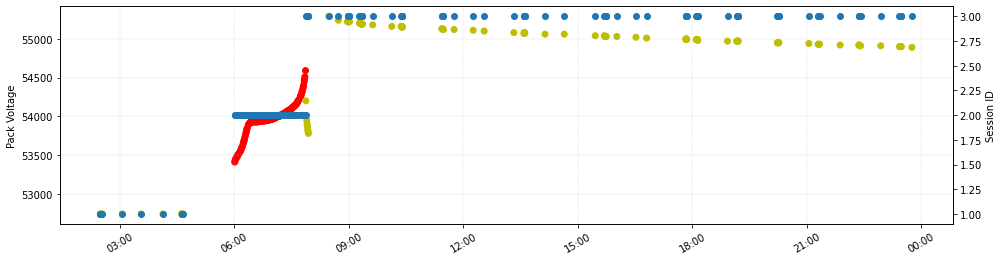

In [ ]:
# Session-wise plot
plot_df          = df   #[~(veh_batt_df['state']== charging_state)]
marker_color_map = np.where(plot_df['state']== charging_state,'r',np.where(plot_df['state']==discharging_state,'b','y'))

fig, ax = plt.subplots(figsize = (16, 4))
ax.scatter(plot_df['indian_time'], plot_df[pack_voltage], c = marker_color_map)
ax.xaxis.set_major_formatter(time_ticks)
ax.xaxis.set_tick_params(rotation = 30, labelsize = 10)
ax.set_ylabel('Pack Voltage')
session_ax = ax.twinx()
session_ax.plot(plot_df['indian_time'].values, plot_df['session_id'].values, 'o')
session_ax.set_ylabel('Session ID')
ax.grid(linewidth = 0.4, linestyle = ':')

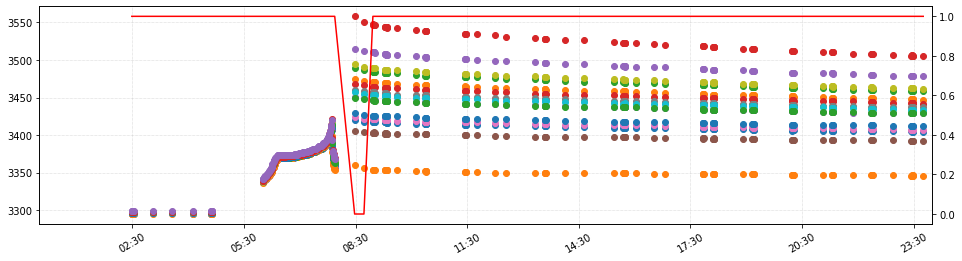

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (16,4))
ax.plot(plot_df['indian_time'].values, plot_df[str_volt_columns].values, 'o')
ax.set_ylabel('String Voltage')
ax2 = plt.twinx()
ax2.plot(plot_df['indian_time'].values, plot_df['allow_charging'].values, 'r-')
ax2.set_ylabel('Allow_charging_Flag')
ax.grid(linestyle = ':', linewidth = 0.5)
ax.set_xlim(pd.to_datetime(summary_dict['data_date']+ ' 00:00:00 +05:30'), \
            pd.to_datetime(summary_dict['data_date']+ ' 23:59:59 +05:30'))
ax.xaxis.set_major_formatter(time_ticks)
ax.xaxis.set_tick_params(rotation = 30, labelsize = 10)
plt.show()

In [ ]:
ax.get_xlim()

(19902.829966483798, 19903.805049719907)

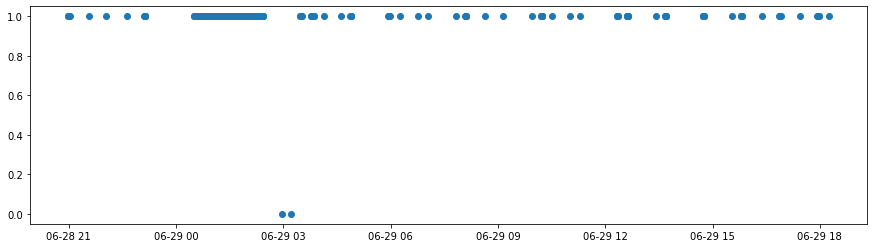

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (15,4))
ax.plot(plot_df['indian_time'].values, plot_df['allow_charging'].values, 'o')
plt.show()

# Process day's veh_batt_data

In [ ]:
def get_batt_summary_dict(summary_dict, batt_df):
    batt_df              = add_time_columns(batt_df)
    # battery summary
    summary_dict['batt_telemetry_count']  = batt_df.shape[0]
    
    for col_name in float_cols:
        batt_df[col_name] = batt_df[col_name].astype(float)
    
    batt_df[pack_voltage]      = batt_df[pack_voltage]     * 1000.
    batt_df[str_volt_columns]  = batt_df[str_volt_columns] * 1000.
    batt_df[pack_current]      = batt_df[pack_current]     * 1000.
    
    # Creating charge current column and discharge column from pack current column
    batt_df[pack_chg_current]    = 0.
    batt_df[pack_dischg_current] = 0.
    
    batt_df.loc[batt_df['load_status']   == 4.,  pack_chg_current]    = \
                                                batt_df.loc[batt_df['load_status']   == 4.,  pack_current].values
    batt_df.loc[~(batt_df['load_status'] == 4.), pack_dischg_current] = \
                                                batt_df.loc[~(batt_df['load_status'] == 4.), pack_current].values
    # Create Sessions
    summary_dict, batt_df = get_state_session_id(summary_dict, batt_df)

    # Charge Discharge Statistics
    if pack_dischg_current in batt_df.columns:
        dischg_batt_df    = batt_df[batt_df['state'] == discharging_state]
        summary_dict      = get_dischg_usage_vals(dischg_batt_df, summary_dict)

    if pack_chg_current in batt_df.columns:
        chg_batt_df       = batt_df[batt_df['state'] == charging_state]
        summary_dict      = get_chg_usage_vals(chg_batt_df, summary_dict)
    
    diff_time_secs = batt_df['diff_time_secs']
    summary_dict['missing_data_mins']       = np.sum(diff_time_secs[diff_time_secs > max_disconnexn_time_secs]) / 60.
    summary_dict['idle_time_hrs']           = 24. - (summary_dict['dischg_time_Hrs']   + 
                                                     summary_dict['chg_time_Hrs']      - 
                                                     summary_dict['missing_data_mins'] / 60.)
    # Get string Imbalance
    summary_dict, string_Ergy_batt_df = get_stringwise_energy(summary_dict, batt_df)
    summary_dict['batt_df'] = batt_df
    return summary_dict

In [ ]:
# Process day's vehicle's drive & GPS data
def get_driv_summary_dict(summary_dict, driv_df):
    driv_df              = add_time_columns(driv_df)
    summary_dict['driv_telemetry_count'] = driv_df.shape[0]
    driv_df['odometer']  = driv_df['odometer'].astype(float)
    summary_dict         = eChargeUp_utils.get_distance_gap(driv_df['odometer'], summary_dict)
    
    summary_dict['driv_df'] = driv_df
    return summary_dict

In [ ]:
def process_daily_data(root_dir_chargeup_data, reqd_date_dir):
    batt_data_dir = root_dir_chargeup_data + '/' + reqd_date_dir
    #print(batt_data_dir)

    no_batt_data_dict_list      = []
    veh_batt_summary_dicts_list = []
    for file_name in os.listdir(batt_data_dir)[:]:
        #---------Trick to Ignore Green Cell bus data
        if file_name.lower().startswith('green'): continue
        
        #if file_name != 'CGF24D0016.parquet': continue # Trick to make it work for single file only
        #-----------------
        #print(file_name)
        df = pd.read_parquet(batt_data_dir + '/' + file_name)
        #------------ Empty DataFrame Handling
        if df.empty:
            no_batt_cols_dict               = {}
            no_batt_cols_dict['file_name']  = file_name
            no_batt_cols_dict['date']       = reqd_date_dir
            no_batt_data_dict_list.append(no_batt_cols_dict)
            continue
        #------------ 
        df[timestamp]                  = df[timestamp].astype('datetime64[ms]')
        vehicle_ID                     = file_name.replace('.parquet', '')
        # Splits df to 3 dataframe copies while retaining timestamp column in each
        batt_df,   missing_batt_cols   = get_reqd_df_cols(df, batt_data_columns)
        alerts_df, missing_alerts_cols = get_reqd_df_cols(df, batt_alerts_columns)
        driv_df,   missing_driv_cols   = get_reqd_df_cols(df, driv_data_columns)

        summary_dict                          = {}
        summary_dict['vehicle_ID']            = vehicle_ID
        summary_dict['date']                  = reqd_date_dir        
        summary_dict['missing_alerts_cols']   = missing_alerts_cols
        summary_dict['missing_batt_cols']     = missing_batt_cols
        summary_dict['missing_driv_cols']     = missing_driv_cols
        
        #----------------------------------
        if not alerts_df.empty:
            
            summary_dict['alerts_df'] = eChargeUp_utils.process_alerts(alerts_df)
            alerts_df                 = add_time_columns(alerts_df)
        if not batt_df.empty:
            
            summary_dict         = get_batt_summary_dict(summary_dict, batt_df)
            if plot_graphs == True:
                make_veh_batt_usage_plot(vehicle_ID, reqd_date_dir, summary_dict['batt_df'])

        if not driv_df.empty:
            summary_dict         = get_driv_summary_dict(summary_dict, driv_df)
            
        veh_batt_summary_dicts_list.append(summary_dict)


    no_batt_cols_vehs_df = pd.DataFrame(no_batt_data_dict_list)
    vehs_batt_summary_df = pd.DataFrame(veh_batt_summary_dicts_list)
    missing_cols_vehs_df = vehs_batt_summary_df[['vehicle_ID', 'date', 'missing_batt_cols', \
                                                 'missing_alerts_cols', 'missing_driv_cols' ]]
    return vehs_batt_summary_df, no_batt_cols_vehs_df, missing_cols_vehs_df

'CGR10145'

,string_num,chg_ergy_Wh,dischg_ergy_Wh,chg_ergy_%gap,dischg_ergy_%gap,abs_%ergy_gap,%ergy_gap
0,V2,315.04,312.60,0.04,0.01,0.04,0.04
1,V3,314.79,312.21,-0.04,-0.12,0.16,-0.16
2,V4,314.80,312.01,-0.04,-0.18,0.22,-0.22
3,V5,315.03,312.31,0.03,-0.09,0.12,-0.05
4,V6,314.79,312.36,-0.04,-0.07,0.11,-0.11
5,V7,314.95,312.56,0.01,-0.01,0.01,0.00
6,V8,314.98,312.76,0.02,0.06,0.08,0.08
7,V9,314.98,312.52,0.02,-0.02,0.04,-0.00
8,V10,315.34,311.93,0.13,-0.21,0.34,-0.08
9,V11,315.10,312.42,0.06,-0.05,0.11,0.00


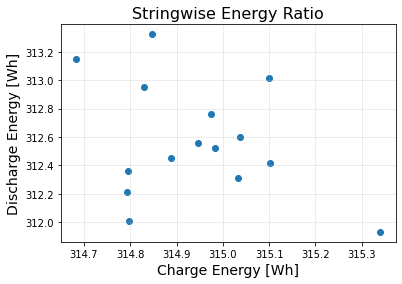

'CGR10266'

,string_num,chg_ergy_Wh,dischg_ergy_Wh,chg_ergy_%gap,dischg_ergy_%gap,abs_%ergy_gap,%ergy_gap
0,V2,485.80,470.45,0.04,-0.05,0.09,-0.02
1,V3,483.94,470.54,-0.35,-0.03,0.38,-0.38
2,V4,486.07,468.90,0.09,-0.38,0.47,-0.29
3,V5,486.47,470.12,0.17,-0.12,0.30,0.05
4,V6,485.68,470.77,0.01,0.02,0.03,0.03
5,V7,486.19,471.51,0.12,0.17,0.29,0.29
6,V8,486.37,470.46,0.15,-0.05,0.20,0.10
7,V9,484.70,470.39,-0.19,-0.07,0.26,-0.26
8,V10,483.86,470.54,-0.36,-0.03,0.40,-0.40
9,V11,485.68,471.17,0.01,0.10,0.11,0.11


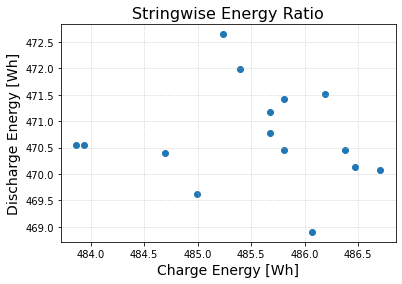

'CGR10160'

,string_num,chg_ergy_Wh,dischg_ergy_Wh,chg_ergy_%gap,dischg_ergy_%gap,abs_%ergy_gap,%ergy_gap
0,V2,402.50,328.84,-0.05,-0.15,0.21,-0.21
1,V3,402.38,328.98,-0.08,-0.11,0.20,-0.20
2,V4,402.37,329.19,-0.09,-0.05,0.13,-0.13
3,V5,402.70,329.28,-0.00,-0.02,0.02,-0.02
4,V6,402.56,329.30,-0.04,-0.01,0.05,-0.05
5,V7,402.62,329.47,-0.02,0.04,0.06,0.01
6,V8,403.24,329.36,0.13,0.01,0.13,0.13
7,V9,402.77,329.18,0.01,-0.05,0.06,-0.04
8,V10,402.73,329.19,0.00,-0.05,0.05,-0.04
9,V11,403.22,329.85,0.13,0.15,0.28,0.28


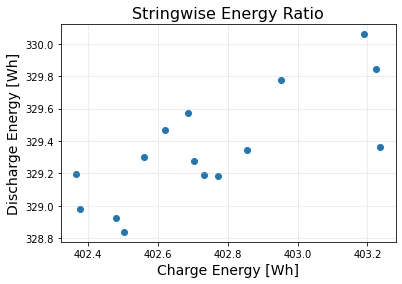

'CGF24E0003'

,string_num,chg_ergy_Wh,dischg_ergy_Wh,chg_ergy_%gap,dischg_ergy_%gap,abs_%ergy_gap,%ergy_gap
0,V2,519.32,512.80,-0.06,-0.05,0.11,-0.11
1,V3,519.34,512.84,-0.06,-0.04,0.10,-0.10
2,V4,519.49,512.97,-0.03,-0.02,0.05,-0.05
3,V5,519.65,513.02,0.00,-0.01,0.01,-0.00
4,V6,519.62,513.09,-0.00,0.01,0.01,0.00
5,V7,519.58,512.97,-0.01,-0.01,0.03,-0.03
6,V8,519.58,512.75,-0.01,-0.06,0.07,-0.07
7,V9,519.83,512.94,0.04,-0.02,0.06,0.02
8,V10,519.77,513.21,0.02,0.03,0.06,0.06
9,V11,519.65,513.06,0.00,0.00,0.00,0.00


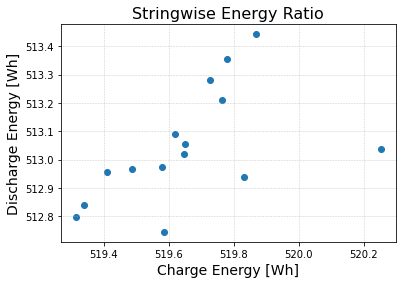

'CGF24D0024'

,string_num,chg_ergy_Wh,dischg_ergy_Wh,chg_ergy_%gap,dischg_ergy_%gap,abs_%ergy_gap,%ergy_gap
0,V2,346.53,339.54,-0.02,-0.00,0.03,-0.03
1,V3,346.49,339.42,-0.03,-0.04,0.07,-0.07
2,V4,346.60,339.57,-0.00,0.01,0.01,0.00
3,V5,346.54,339.48,-0.02,-0.02,0.04,-0.04
4,V6,346.47,339.59,-0.04,0.01,0.05,-0.03
5,V7,346.54,339.59,-0.02,0.01,0.03,-0.01
6,V8,346.64,338.98,0.01,-0.17,0.18,-0.16
7,V9,347.79,337.36,0.34,-0.65,0.99,-0.30
8,V10,346.69,339.58,0.02,0.01,0.03,0.03
9,V11,346.66,339.60,0.01,0.01,0.03,0.03


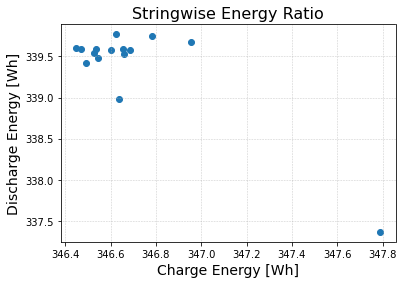

CPU times: total: 6.44 s
Wall time: 7.49 s


In [ ]:
%%time
reqd_date_dir =  'dummy_date'   #'2024-07-01'
save_dir      = output_data_dir + '/' + reqd_date_dir

vehs_batt_summary_df, no_batt_cols_vehs_df, missing_cols_vehs_df = process_daily_data(root_dir_chargeup_data, reqd_date_dir)

In [ ]:
data = {}
data['no_batt_cols_vehs_df'] = no_batt_cols_vehs_df
data['missing_cols_vehs_df'] = missing_cols_vehs_df
data['vehs_batt_summary_df'] = vehs_batt_summary_df
eChargeUp_utils.compressed_pickle('./'+reqd_date_dir+'_veh_data_summary.pbzip2', data)

In [ ]:
vehs_batt_summary_df.columns

Index(['vehicle_ID', 'alerts_df', 'start_odometer', 'end_odometer',
       'drive_distance', 'batt_telemetry_count', 'sessions_df',
       'dischg_cap_Ah', 'dischg_ergy_kWh', 'dischg_time_Hrs',
       'dischg_max_curr_Amps', 'dischg_mean_curr_Amps', 'dischg_FCE',
       'chg_cap_Ah', 'chg_ergy_kWh', 'chg_time_Hrs', 'chg_max_curr_Amps',
       'chg_mean_curr_Amps', 'chg_FCE', 'missing_data_mins', 'idle_time_hrs',
       'max_abs_%Ergy_gap', 'max_abs_%Ergy_gap_string', 'string_Ergy_df',
       'date'],
      dtype='object')

In [ ]:
#-----------------------------------------------------------
def write_dfs_to_tabs(xl_writer, df_sheetname_tuples_list):
    for (df, sheet_name) in df_sheetname_tuples_list:
        if not df.empty:
            df.to_excel(xl_writer, sheet_name = sheet_name, startrow = 1 , startcol = 1)
    return xl_writer
#-----------------------------------------------------------
reqd_excel_columns = ['vehicle_ID', 'start_odometer', 'end_odometer',
       'drive_distance', 'batt_telemetry_count', 'dischg_cap_Ah', 'dischg_ergy_kWh', 'dischg_time_Hrs',
       'dischg_max_curr_Amps', 'dischg_mean_curr_Amps', 'dischg_FCE',
       'chg_cap_Ah', 'chg_ergy_kWh', 'chg_time_Hrs', 'chg_max_curr_Amps',
       'chg_mean_curr_Amps', 'chg_FCE', 'missing_data_mins', 'idle_time_hrs',
       'max_abs_%Ergy_gap', 'max_abs_%Ergy_gap_string', 'date']

In [ ]:
xl_file_path  = './' + reqd_date_dir + '_veh_data_limited_summary.xlsx'
xl_writer     = pd.ExcelWriter(xl_file_path, engine='xlsxwriter')   

# list of tuples of dataframe and xl_sheet_name
df_sheetname_tuples_list = [(vehs_batt_summary_df[reqd_excel_columns] ,       'batt_usage_summary') ,
                            (no_batt_cols_vehs_df,        'No_battery_data')    ,
                            (missing_cols_vehs_df,        'Missing_batt_data_columns')
                           ]

xl_writer = write_dfs_to_tabs(xl_writer, df_sheetname_tuples_list)
xl_writer.close()


In [ ]:
# Validate the compressed pickle file
data_dict = eChargeUp_utils.decompress_pickle('./'+reqd_date_dir+'_veh_data_summary.pbzip2')
data_dict.keys()

dict_keys(['no_batt_cols_vehs_df', 'missing_cols_vehs_df', 'vehs_batt_summary_df'])

In [ ]:
vehs_batt_summary_df = data_dict['vehs_batt_summary_df']
#vehs_batt_summary_df['vehicle_ID'].to_list()
veh_alert_only = vehs_batt_summary_df[(~vehs_batt_summary_df['alerts_df'].isnull())]

veh_alert_only.iloc[0]['alerts_df'].columns

In [ ]:
df.memory_usage(deep = True).sum()/1024

12539.9384765625

In [ ]:
veh_alerts_df.memory_usage(deep = True).sum()/1024

5.578125

In [ ]:
display(veh_batt_df.memory_usage(deep = True).sum()/1024)

5732.2333984375

In [ ]:
veh_driv_df.memory_usage(deep = True).sum()/1024

295.45703125

In [ ]:
# summary_columns
df.loc[df[summary_columns[:]].notnull().any(axis=1)][summary_columns].drop_duplicates()

,cycle_count,SoH
0,11.0,100.0
1015,12.0,100.0


In [ ]:
# Fixed Columns
df.loc[df[fixed_columns[:]].notnull().any(axis=1)][fixed_columns].drop_duplicates()

,chemistry,bms_id,battery_capacity
0,2.0,2095522944.0,100.0


# Finding alerts and timestamps

In [ ]:
# Finding alerts and timestamps
#----------- Remove None rows
veh_alerts_df = df.loc[df[batt_alerts_columns[1:]].notnull().any(axis=1)][batt_alerts_columns]
#display(veh_alerts_df.columns)
#----------- Convert string values to numbers
for col_name in veh_alerts_df.columns[1:]:
    veh_alerts_df[col_name] = veh_alerts_df[col_name].astype(float).astype(int)
#display(#veh_alerts_df[veh_alerts_df.columns[1:]].sum())
#display(veh_alerts_df.columns)
#----------- Drop alert columns with no alerts
for col_name in veh_alerts_df.columns[1:]:
    #print(col_name, veh_alerts_df[col_name].unique())
    if (veh_alerts_df[col_name] == 0.).all():
        veh_alerts_df = veh_alerts_df.drop(columns = [col_name])
#display(veh_alerts_df.columns)
#----------- Drop rows with no alerts
veh_alerts_df = veh_alerts_df.loc[(veh_alerts_df[veh_alerts_df.columns[1:]] != 0.).all(axis = 1)]
with pd.option_context('display.max_rows', None):
    display(veh_alerts_df)

,timestamp,alert_cell_over_voltage_charged,alert
1460,1719229759139,1,2
1461,1719229789138,1,2
1462,1719229819139,1,2
1463,1719229849138,1,2
1464,1719229879139,1,2
1465,1719229909139,1,2
1469,1719230029139,1,2
1470,1719230059139,1,2
1471,1719230089139,1,2
1472,1719230119139,1,2


# Getting Battery data dataframe

In [ ]:
veh_batt_df = df.loc[df[batt_data_columns[1:]].notnull().any(axis=1)][batt_data_columns]

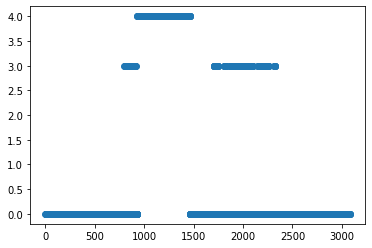

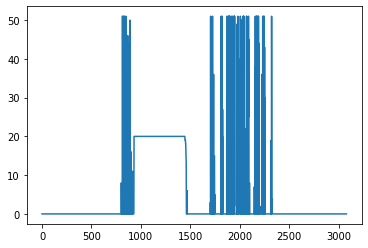

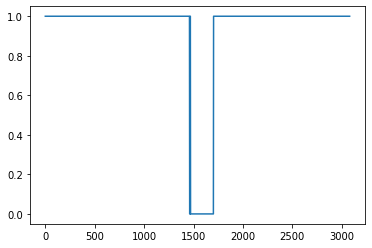

In [ ]:
plt.plot(veh_batt_df['load_status'].astype(float).astype(int), 'o')
plt.show()
plt.plot(veh_batt_df['Ip'].astype(float).astype(int))
plt.show()
plt.plot(veh_batt_df['allow_charging'].astype(float).astype(int))

# Getting Running data dataframe

In [ ]:
veh_driv_df = df.loc[df[driv_data_columns[1:]].notnull().any(axis=1)][driv_data_columns]

In [ ]:
df.dtypes

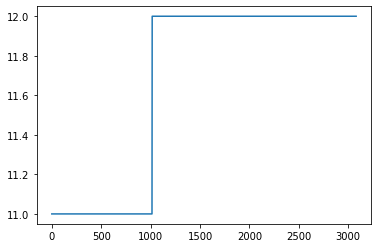

In [ ]:
#plt.plot(df['input_voltage'][~(df['input_voltage'].isnull())].astype(float).values)
plt.plot(df['cycle_count'][~(df['cycle_count'].isnull())].astype(float).values)
#plt.plot(df['Ip'].astype(float))
plt.show()

In [ ]:
#plt.plot(df['load_status'].astype(int))
#plt.plot(df['Ip'].astype(float))
#plt.show()

In [ ]:
#date_string = veh_df['indian_time'].iloc[0].date().strftime("%d-%b-%Y")

In [ ]:
for col_name in df[['status', 'numsatu','bms_id', 'chemistry']]:
    display(df[col_name].unique())

array([None, '0.0'], dtype=object)

array([None, '19.0', '20.0', '22.0', '21.0', '18.0', '17.0', '16.0',
       '15.0', '14.0', '23.0', '13.0'], dtype=object)

array(['2095522944.0', None], dtype=object)

array(['2.0', None], dtype=object)

In [ ]:
veh_driv_df = df[driv_data_columns]
veh_batt_df = df[batt_data_columns]
alerts_columns = df[alerts_columns]

In [ ]:
df.to_excel('./dummy.xlsx')

In [ ]:
dummy_power = df[['Ip', 'Vp']].dropna()
plt.plot(dummy_power.astype(float).values, '-')
ax2 = plt.twinx()
ax2.plot()
plt.show()